## Step 0:import packet

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import time
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.init as init

from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader,Dataset,random_split
from torchvision import datasets,transforms,models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow import keras
from PIL import Image

torch.__version__ 

'2.1.0+cpu'

In [2]:
%run "1_magpy_generate_data.ipynb"

磁铁空间位置向量大小： (9216, 6)


产生磁场大小: (36, 3)
magnetpose与sensor数量: (9216, 108)
磁铁位置与传感器位置和输出数据标签： 114
传感器输出数据： (9216, 114)
多姿态传感器的输出矩阵： (9216, 108)
多姿态传感器的输出矩阵方差： 0.0015418675705863628
sensor数据帧: (9216, 6, 6, 3)


## Step 1: just_data

In [3]:
def get_data(features, labels,bs):
    """ Returns Data for training"""
    # Assuming you have 'features' and 'labels' that contain your data
    features = features
    labels = labels
    #标准化处理输入数据
    # features = preprocessing.StandardScaler().fit_transform(features)
    labels = preprocessing.StandardScaler().fit_transform(labels)
    x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.1, random_state=42)

    # map x_train and y_train , x_valid and y_valid
    x_train, y_train,x_valid,y_valid = map(
        torch.tensor,(x_train,y_train,x_valid,y_valid)
    )

    x_train = torch.tensor(x_train, dtype = torch.float)
    # y_train = F.one_hot(y_train.to(torch.int64), num_classes=10)    # n为类别数
    # y_train = torch.tensor(y_train)
    x_valid = torch.tensor(x_valid, dtype = torch.float)
    # y_valid = F.one_hot(y_valid.to(torch.int64), num_classes=10)    # n为类别数
    # y_valid = torch.tensor(y_valid)


    # Create DataLoaders for the training and test sets
    train_ds = TensorDataset(x_train, y_train)
    valid_ds = TensorDataset(x_valid, y_valid)
    return (
    DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True),
    DataLoader(valid_ds, batch_size=bs*2),
    )

### check data
def check_get_data_loader(train_dl):
    for batch in enumerate(train_dl):
        # Each batch is a tuple containing input data and labels
        inputs, labels = batch
        # Print or examine the batch data
        print("Batch input data:")
        print(inputs)
        print("Batch labels:")
        print(labels)

## Step 2: Create net

In [4]:
from torch import max_pool2d

class Linear_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(108, 4096)  # 输入层2个特征，隐藏层64个神经元
        self.Linear2 = nn.Linear(4096, 1024)  # 隐藏层64个神经元，隐藏层32个神经元
        self.out = nn.Linear(1024,1)

    def forward(self, x):
        x = torch.relu(self.Linear1(x))
        x = torch.relu(self.Linear2(x))
        x = self.out(x)
        return x
    
 
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(                  #input shape (3,6,6)    
                in_channels=3,          # 彩色图     
                out_channels=16,        # 得到几个特征图    
                kernel_size=3,          # 卷积核大小  如果左右两个数不同，比如3x5的卷积核，那么写作kernel_size = (3, 5)
                stride=1,               # 卷积步长
                padding=2               # 补0
            ),                          ##  output shape (16,8,8)  O = （I - K + 2P）/ S +1    (28 - 3 + 1*2)/1 + 1   N=(W+2P-F)/S+1   28 + 2 * 2 -3 /1 +1

            nn.ReLU(),                  # 分段线性函数，把所有的负值都变为0，而正值不变，即单侧抑制
            nn.MaxPool2d(kernel_size=2),#2x2采样，8/2=4，output shape (16,4,4) maxpooling有局部不变性而且可以提取显著特征的同时降低模型的参数，从而降低模型的过拟合
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 2), 

            nn.ReLU(),
            nn.MaxPool2d(2)
        )                               #output shape (32,3,3)  
        
        self.fc1 = nn.Linear(32*3*3, 64) # 全连接层 7*7*32,

        self.fc2 = nn.Linear(64, 1) # 全连接层 7*7*32, num_classes

    def forward(self, x):
        x = self.conv1(x) 
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 保留batch, 将后面的乘到一起 [batch, 32*7*7]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class CNN_new_Net(nn.Module):
    def __init__(self):
        super(CNN_new_Net,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(                  #input shape (3,6,6)    
                in_channels=3,          # 彩色图     
                out_channels=16,        # 得到几个特征图    
                kernel_size=3,          # 卷积核大小  如果左右两个数不同，比如3x5的卷积核，那么写作kernel_size = (3, 5)
                stride=1,               # 卷积步长
                padding=2               # 补0
            ),                          ##  output shape (16,8,8)  O = （I - K + 2P）/ S +1    (28 - 3 + 1*2)/1 + 1   N=(W+2P-F)/S+1   28 + 2 * 2 -3 /1 +1

            nn.ReLU(),                  # 分段线性函数，把所有的负值都变为0，而正值不变，即单侧抑制
            nn.MaxPool2d(kernel_size=2),#2x2采样，8/2=4，output shape (16,4,4) maxpooling有局部不变性而且可以提取显著特征的同时降低模型的参数，从而降低模型的过拟合
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 2), 

            nn.ReLU(),
            nn.MaxPool2d(2)
        )                               #output shape (32,3,3)  
        
        self.fc1 = nn.Linear(32*3*3, 64) # 全连接层 7*7*32,

        self.fc2 = nn.Linear(64, 1) # 全连接层 7*7*32, num_classes
    def forward(self, x):
        x = self.conv1(x) 
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 保留batch, 将后面的乘到一起 [batch, 32*7*7]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        init.constant_(m.weight,0.1)
        init.constant_(m.bias, 0.1) # type: ignore



## : net model 
def get_model(net_model,learning_rate):
        model = net_model
        # model.apply(weights_init)
        optimizer = optim.SGD(model.parameters(), lr = learning_rate)
        scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))
        return model, optimizer, scheduler


    

## Step 3: loss function

In [5]:
def loss_batch(model, loss_func, data, target, opt=None,sche=None):
    loss = loss_func(model(data), target) # type: ignore
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    if sche is not None:    
        sche.step()
    return loss.item(),len(data)


## Step 4: fit the model

In [6]:
def fit(Epochs,model,loss_func, opt,sche,train_dl,valid_dl,bs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    losses= []
    nums =[]
    
    for epoch in range(Epochs):        
        # 训练开始
        start_time = time.time()  
        val_loss = []
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_dl):
            input = data.to(device)
            output = target.to(device)
            model.train()
            loss, nums  = zip( 
                *[loss_batch(model,loss_func,input,output,opt)]
            )
            train_loss = np.sum(np.multiply(loss, nums)) / np.sum(nums)
            if(batch_idx % 100 == 0):
                model.eval()
                with torch.no_grad():
                    loss ,nums  = zip(
                        *[loss_batch(model,loss_func, data.to(device),target.to(device)) for data,target in valid_dl]
                    )
                    val_loss = np.sum(np.multiply(loss, nums)) / np.sum(nums)                
        
                # 准确率计算
                print("当前epoch: {} [{}/{} {:.0f}%)],\ttest_losses:{}\tvalid_loss:{}".format(epoch, batch_idx * bs, len(train_dl.dataset),100. * batch_idx / len(train_dl),train_loss,val_loss))
        Epoch_time = time.time()
        print("{:.2f} s ".format(float(Epoch_time-start_time)))
    return model

## step 5: train the model

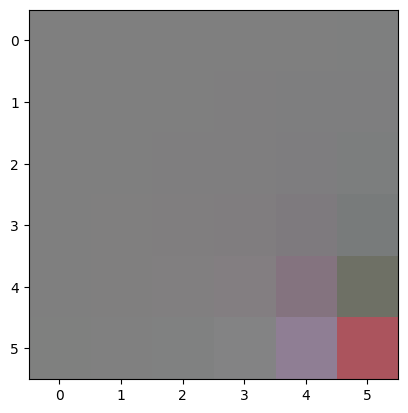

[127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 126, 127, 127, 127, 127, 126, 123, 127, 127, 128, 129, 127, 101, 127, 128, 129, 132, 148, 93]
torch.Size([9216, 3, 6, 6])
(9216, 108) (9216, 1)


C:\Users\Xugx\AppData\Local\Temp\ipykernel_34052\4043225243.py:16: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\Xugx\AppData\Local\Temp\ipykernel_34052\4043225243.py:19: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [21]:
''' ##-------------------------sin_cos---------------------------------------
# theta = np.linspace(-np.pi, np.pi, 1000)  # 创建一些 theta 值
# y1 = np.sin(theta).reshape(-1,1)
# y2 = np.sin(theta/2+np.pi/2+10).reshape(-1,1)
# y3 = np.sin(2*theta+np.pi/6-1).reshape(-1,1)
# features = np.hstack((y1, y2, y3))
##-------------------------sin_cos---------------------------------------'''

''' ##-------------------------mnint---------------------------------------
(features, labels),(features1, labels1)  = keras.datasets.mnist.load_data()
features = features.reshape(60000,1,28,28)
##-------------------------mnint---------------------------------------'''

features = My_Magic_u.sensor_imag_data 
labels = My_Magic_u.magpos_data
i = 9000
plt.imshow(features[i])
plt.show()
print(list(features[i].getdata(band = 2)))
tensor_img = torch.tensor(np.array(features),dtype=torch.float)
tensor_i = torch.transpose(tensor_img,1,3)
print(tensor_i.shape)



features = np.array(My_Magic_u.sensor_data)/255
labels = np.array(labels[:,1]).reshape(-1,1)
# labels = theta.reshape(-1,1)
print(features.shape,labels.shape)
batch_size = 64
train_dl, valid_dl = get_data(features,labels, bs=batch_size)
# # check_get_data_loader(train_dl)
model, opt,sche = get_model(Linear_Net(),learning_rate= 0.001)
# print(train_dl)
# print(valid_dl)
# print(model)
# print(opt)



In [22]:
loss_func = nn.CrossEntropyLoss()
train_finish_model = fit(5, model, loss_func, opt, sche , train_dl, valid_dl, bs = batch_size)

cpu
当前epoch: 0 [0/8294 0%)],	test_losses:0.0	valid_loss:0.0
当前epoch: 0 [6400/8294 77%)],	test_losses:0.0	valid_loss:0.0
2.25 s 
当前epoch: 1 [0/8294 0%)],	test_losses:0.0	valid_loss:0.0
当前epoch: 1 [6400/8294 77%)],	test_losses:0.0	valid_loss:0.0
2.25 s 
当前epoch: 2 [0/8294 0%)],	test_losses:0.0	valid_loss:0.0
当前epoch: 2 [6400/8294 77%)],	test_losses:0.0	valid_loss:0.0
2.17 s 
当前epoch: 3 [0/8294 0%)],	test_losses:0.0	valid_loss:0.0
当前epoch: 3 [6400/8294 77%)],	test_losses:0.0	valid_loss:0.0
2.20 s 
当前epoch: 4 [0/8294 0%)],	test_losses:0.0	valid_loss:0.0
当前epoch: 4 [6400/8294 77%)],	test_losses:0.0	valid_loss:0.0
2.15 s 


## step 5: save the model and reload

In [23]:
for name, parameter in model.named_parameters():
    print(name,parameter,parameter.size())


Linear1.weight Parameter containing:
tensor([[ 0.0406, -0.0137,  0.0778,  ..., -0.0737, -0.0900, -0.0712],
        [ 0.0614,  0.0329, -0.0225,  ..., -0.0924, -0.0533, -0.0583],
        [-0.0842,  0.0395, -0.0478,  ..., -0.0735, -0.0064, -0.0745],
        ...,
        [-0.0519,  0.0746, -0.0233,  ...,  0.0498, -0.0516,  0.0774],
        [-0.0865, -0.0816, -0.0190,  ..., -0.0335,  0.0852, -0.0837],
        [ 0.0901, -0.0161, -0.0893,  ...,  0.0499, -0.0608,  0.0706]],
       requires_grad=True) torch.Size([4096, 108])
Linear1.bias Parameter containing:
tensor([-0.0637,  0.0137, -0.0461,  ...,  0.0555,  0.0920, -0.0185],
       requires_grad=True) torch.Size([4096])
Linear2.weight Parameter containing:
tensor([[-0.0017,  0.0061, -0.0033,  ...,  0.0013,  0.0018,  0.0017],
        [-0.0069,  0.0107,  0.0006,  ..., -0.0102, -0.0019,  0.0125],
        [-0.0003, -0.0055,  0.0030,  ...,  0.0103, -0.0133,  0.0047],
        ...,
        [-0.0005,  0.0081,  0.0105,  ..., -0.0018, -0.0009,  0.0120]

In [24]:
def save_model(model,file_path):
    torch.save(model.state_dict(),file_path) # type: ignore
def load_model(net_class,path):
    model = net_class
    model.load_state_dict(torch.load(path))
    return model

In [25]:
model_path = "../../model/magpy_nn_model.pt"
save_model(model,model_path)
t_model = load_model(Linear_Net(), model_path)
for name, parameter in t_model.named_parameters():
    print(name,parameter,parameter.size())



Linear1.weight Parameter containing:
tensor([[ 0.0406, -0.0137,  0.0778,  ..., -0.0737, -0.0900, -0.0712],
        [ 0.0614,  0.0329, -0.0225,  ..., -0.0924, -0.0533, -0.0583],
        [-0.0842,  0.0395, -0.0478,  ..., -0.0735, -0.0064, -0.0745],
        ...,
        [-0.0519,  0.0746, -0.0233,  ...,  0.0498, -0.0516,  0.0774],
        [-0.0865, -0.0816, -0.0190,  ..., -0.0335,  0.0852, -0.0837],
        [ 0.0901, -0.0161, -0.0893,  ...,  0.0499, -0.0608,  0.0706]],
       requires_grad=True) torch.Size([4096, 108])
Linear1.bias Parameter containing:
tensor([-0.0637,  0.0137, -0.0461,  ...,  0.0555,  0.0920, -0.0185],
       requires_grad=True) torch.Size([4096])
Linear2.weight Parameter containing:
tensor([[-0.0017,  0.0061, -0.0033,  ...,  0.0013,  0.0018,  0.0017],
        [-0.0069,  0.0107,  0.0006,  ..., -0.0102, -0.0019,  0.0125],
        [-0.0003, -0.0055,  0.0030,  ...,  0.0103, -0.0133,  0.0047],
        ...,
        [-0.0005,  0.0081,  0.0105,  ..., -0.0018, -0.0009,  0.0120]

In [31]:
for batch_idex , (xb,yb) in  enumerate(valid_dl):
    print(t_model(xb)-yb)

    # print(loss_func(t_model(xb),yb))#计算真实值和预测值之间的误差

tensor([[-1.4606],
        [ 1.4671],
        [-1.4605],
        [ 0.2961],
        [ 1.4671],
        [-0.8750],
        [-0.2895],
        [-0.8750],
        [ 0.2961],
        [-0.8750],
        [-0.8750],
        [-0.8750],
        [-0.2895],
        [-0.8750],
        [-0.8750],
        [ 0.8816],
        [-0.8750],
        [ 0.2961],
        [-1.4605],
        [ 1.4672],
        [ 0.8816],
        [-1.4605],
        [-1.4606],
        [ 0.2961],
        [-1.4605],
        [ 0.2961],
        [-0.2895],
        [ 0.2961],
        [ 1.4671],
        [ 0.2961],
        [ 0.8816],
        [-1.4606],
        [ 0.2961],
        [ 0.2961],
        [ 0.2961],
        [-1.4605],
        [ 0.8816],
        [ 0.8817],
        [ 0.8816],
        [-0.2895],
        [ 0.8816],
        [-0.8750],
        [ 1.4672],
        [-0.8751],
        [ 1.4671],
        [ 1.4672],
        [-1.4606],
        [ 0.2961],
        [-1.4606],
        [ 1.4671],
        [-1.4605],
        [-0.8750],
        [ 1.

In [27]:
thetalist = []
predicted_thetalist = []
for i in range(100):
    theta = (i-50) * np.pi / 100
    thetalist.append(theta)
    y1 = np.sin(theta).reshape(-1,1)
    y1 = np.sin(theta)
    y2 = np.sin(theta/2+np.pi/2+10)
    y3 = np.sin(2*theta+np.pi/6-1)
    test_inputs = torch.tensor([[y1, y2, y3]], dtype=torch.float32)  # 用 sin(π/6) 和 cos(π/3) 进行测试
    predicted_theta = t_model(test_inputs)
    predicted_thetalist.append(predicted_theta.item())

plt.plot(thetalist,predicted_thetalist)
plt.plot(range(-2,3),range(-2,3))
plt.show()  

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 108x4096)

## Step2 用DataLoader加载数据
转为tensor：好比与Numpy或者pandas，关键特性是自动求导，表示一个多维矩阵。可以用GPU加速
- dataset类用于定义数据集，
  -    \_\_getitem__(self, index)：传入参数index为下标，返回数据集中对应下标的数据组（数据和标签）
  -    \_\_len__(self)：返回数据集的大小
- sampler类是采样器的类，用于定义从数据集中选出数据的规则，随机，顺序
- dataloader数据加载类，对dataset和sampler包装  

tensor不能反向传播，variable可以反向传播。 

In [ ]:
# 定义GetLoader类，继承Dataset方法，并重写__getitem__()和__len__()方法
class MagetData(Dataset): #继承Dataset
	# 初始化函数，得到数据
    def __init__(self, data, data_label): #__init__是初始化该类的一些基础参数
        self.data = data  # 数据
        self.label = data_label #数据标签
        
    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index): #根据索引index返回dataset[index]
        data = self.data[index]
        labels = self.label[index]
        return data, labels
    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self): 
        return len(self.data)


# 数据，大小为 source_data_shape = 9216,6,6,3
source_data = np.array(My_Magic_u.sensor_data)
# 标签，大小为 source_label_shape = 9216,6
source_label = np.array(My_Magic_u.magpos_data)

# 通过GetLoader将数据进行加载，返回Dataset对象，包含data和labels # 创建一个数据集对象
dataset = MagetData(source_data, source_label)
# 读取数据 # 创建一个数据加载器，num_workers>0,要在运行的部分放进main()函数中，不然报错
dataloader = DataLoader(
    dataset = dataset, 
    batch_size = batch_size, 
    shuffle = False, 
    drop_last = False, 
    num_workers = 0
)

# //////////////////打印数据////////////////////////////////
# for i, data in enumerate(datas):
# 	# i表示第几个batch， data表示该batch对应的数据，包含data和对应的labels
#     print("第 {} 个Batch \n{}".format(i, data))


# 将数据集分割成训练集和验证集
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# 创建训练集和验证集的数据加载器
train_dataloader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size,
    shuffle = True, 
    num_workers = 0
)
valid_dataloader = DataLoader(
    dataset = valid_dataset, 
    batch_size = batch_size,
    shuffle = True, 
    num_workers = 0
)

# test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000]/255.
# # torch.unsqueeze 返回一个新的张量，对输入的既定位置插入维度 1
 
# test_y = test_data.test_lables[:2000]
# # 数据预处理
 


NameError: name 'batch_size' is not defined

设置超参数

In [ ]:
# 数据预处理
# 将training data转化成torch能够使用的DataLoader，这样可以方便使用batch进行训练
torch.manual_seed(1) # reproducible 将随机数生成器的种子设置为固定值，这样，当调用时torch.rand(x)，结果将可重现
 
# Hyper Parameters
epoches = 2 # 训练迭代次数
batch_size = 10 # 分块送入训练器
learning_rate = 0.001 # 学习率 learning rate

## Step3 定义网络结构

In [ ]:
# 定义网络结构
# 1）class CNN需要·继承·Module 
# 2）需要·调用·父类的构造方法：super(CNN, self).__init__()
# 3）在Pytorch中激活函数Relu也算是一层layer
# 4）需要·实现·forward()方法，用于网络的前向传播，而反向传播只需要·调用·Variable.backward()即可。
# 输入的四维张量[N, C, H, W]
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # nn.Sequential一个有序的容器，神经网络模块将按照在传入构造器的顺序依次被添加到计算图中执行，
        # 同时以神经网络模块为元素的有序字典也可以作为传入参数
        # nn.Conv2d 二维卷积 先实例化再使用 在Pytorch的nn模块中，它是不需要你手动定义网络层的权重和偏置的
        self.conv1 = nn.Sequential( #input shape (1,28,28)
            nn.Conv2d(in_channels=1, #input height 必须手动提供 输入张量的channels数
                      out_channels=16, #n_filter 必须手动提供 输出张量的channels数
                      kernel_size=5, #filter size 必须手动提供 卷积核的大小 
                      # 如果左右两个数不同，比如3x5的卷积核，那么写作kernel_size = (3, 5)，注意需要写一个tuple，而不能写一个列表（list）
                      stride=1, #filter step 卷积核在图像窗口上每次平移的间隔，即所谓的步长
                      padding=2 #con2d出来的图片大小不变 Pytorch与Tensorflow在卷积层实现上最大的差别就在于padding上
            ), # output shape (16,28,28) 输出图像尺寸计算公式是唯一的 # O = （I - K + 2P）/ S +1
            nn.ReLU(), # 分段线性函数，把所有的负值都变为0，而正值不变，即单侧抑制
            nn.MaxPool2d(kernel_size=2) #2x2采样，28/2=14，output shape (16,14,14) maxpooling有局部不变性而且可以提取显著特征的同时降低模型的参数，从而降低模型的过拟合
        ) 
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2), #output shape (32,7,7)
                                  nn.ReLU(),
                                  nn.MaxPool2d(2))
        # 因上述几层网络处理后的output为[32,7,7]的tensor，展开即为7*7*32的一维向量，接上一层全连接层，最终output_size应为10，即识别出来的数字总类别数
        # 在二维图像处理的任务中，全连接层的输入与输出一般都设置为二维张量，形状通常为[batch_size, size]
        self.out = nn.Linear(32*7*7, 10) # 全连接层 7*7*32, num_classes
        
    def forward(self, x):
        x = self.conv1(x) # 卷一次
        x = self.conv2(x) # 卷两次
        x = x.view(x.size(0), -1) #flat (batch_size, 32*7*7) 
        # 将前面多维度的tensor展平成一维 x.size(0)指batchsize的值
        # view()函数的功能根reshape类似，用来转换size大小
        output = self.out(x) # fc out全连接层 分类器
        return output
# 定义网络结构

查看网络

In [ ]:
# 查看网络结构
cnn = CNN()
print(cnn) # 使用print(cnn)可以看到网络的结构详细信息，可以看到ReLU()也是一层layer
# 查看网络结构

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


## Step4 训练

In [ ]:
#optimizer
# 训练 需要特别指出的是记得每次反向传播前都要清空上一次的梯度，optimizer.zero_grad()
# optimizer 可以指定程序优化特定的选项，例如学习速率，权重衰减等
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR) # torch.optim是一个实现了多种优化算法的包
 

# loss_fun CrossEntropyLoss 交叉熵损失
# 信息量：它是用来衡量一个事件的不确定性的；一个事件发生的概率越大，不确定性越小，则它所携带的信息量就越小。
# 熵：它是用来衡量一个系统的混乱程度的，代表一个系统中信息量的总和；信息量总和越大，表明这个系统不确定性就越大。
# 交叉熵：它主要刻画的是实际输出（概率）与期望输出（概率）的距离，也就是交叉熵的值越小，两个概率分布就越接近
loss_func = nn.CrossEntropyLoss() # 该损失函数结合了nn.LogSoftmax()和nn.NLLLoss()两个函数 适用于分类
 

#training loop
# training loop
for epoch in range(EPOCH):
    for i, (x, y) in enumerate(train_loader):
        batch_x = Variable(x)
        batch_y = Variable(y)
        output = cnn(batch_x) # 输入训练数据
        loss = loss_func(output, batch_y) # 计算误差 #　实际输出，　期望输出
        optimizer.zero_grad() # 清空上一次梯度
        loss.backward() # 误差反向传递 只需要调用.backward()即可
        optimizer.step() # cnn的优化器参数更新
# 训练

NameError: name 'LR' is not defined

## Step5 预测结果

In [ ]:
# 预测结果
# cnn.eval()
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
# torch.max(input, dim)函数  
# torch.max(test_output, 1)[1]  取出来indices 每行最大值的索引
# 输入 input是softmax函数输出的一个tensor  
# 输入 dim是max函数索引的维度0/1，0是每列的最大值，1是每行的最大值
# 输出 函数会返回两个tensor，第一个tensor是每行的最大值；第二个tensor是每行最大值的索引。
# squeeze()函数的功能是：从矩阵shape中，去掉维度为1的。例如一个矩阵是的shape是（5， 1），使用过这个函数后，结果为（5，）。
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')
# 预测结果

NameError: name 'test_x' is not defined

In [ ]:


in_channels, out_channels = 3, 3
width, height = 5, 5
kernel_size = 3  #卷积核的大小
batch_size = 5



#生成一个卷积对象   至少需要三个参数
conv_layer = torch.nn.Conv2d(   in_channels = 3,  #输入通道的数量
                                out_channels = 3, #输出通道的数量
                                kernel_size=3, #卷积核尺寸
                                stride=1,         # 卷积核在图上滑动，每隔一个扫一次
                                padding=1,        # 给图外边补上0
                             ) 

output = conv_layer(input)

print(input.shape)
#torch.Size([1, 5, 100, 100])
print(output.shape)
#torch.Size([1, 10, 98, 98])
#相比于100减去了2，是因为采用了3*3的卷积核，将宽度为2边框去除了
print(conv_layer.weight.shape)
#torch.Size([10, 5, 3, 3])
#10为m输出的通道数  5为n输入的通道数  3*3为卷积核的尺寸




[[ 0.00000000e+00  0.00000000e+00  3.79935429e-05 ... -1.53414449e-08
  -1.53415574e-08 -4.90927783e-08]
 [ 0.00000000e+00  0.00000000e+00  3.79935429e-05 ... -1.53415574e-08
  -1.53414449e-08 -4.90927783e-08]
 [ 0.00000000e+00  0.00000000e+00  3.79935429e-05 ... -1.53414449e-08
  -1.53415574e-08 -4.90927783e-08]
 ...
 [ 7.02314560e-09  3.26466850e-08 -2.03259162e-08 ...  9.46041972e-08
   8.91432097e-07  1.67288521e-06]
 [ 1.14736611e-09  4.05434178e-08 -7.87874611e-09 ... -3.95397193e-07
   8.29705685e-07  1.26136134e-06]
 [ 9.67417049e-09  4.80046143e-08  1.54187388e-08 ... -8.83061051e-07
   3.08877641e-07  7.75447961e-07]]


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
